In [1]:
import pandas as pd
import os

current_path = os.getcwd()
print(f"Initial CWD: {current_path}")

if os.path.basename(current_path).lower() == "src":
    print(f"Current directory is already named 'src': {current_path}")
elif os.path.isdir(os.path.join(current_path, "src")):
    print(f"Changing CWD to 'src' subdirectory: {os.path.join(current_path, 'src')}")
    os.chdir(os.path.join(current_path, "src"))
else:
    raise FileNotFoundError(
        f"Could not find 'src' directory. CWD: {current_path}. "
        "Ensure 'src' is a subdirectory or your notebook is in 'src'."
    )
print(f"Final CWD: {os.getcwd()}")

from anomaly_detector.anomaly_detector import IsolationForestAnomalyDetector
from backtesting.sentiment_analyzer_mt5.sentiment_analyzer_mt5 import BacktestSentimentAnalyzer
from backtesting.platform_conector_mt5.platform_connector_mt5 import BacktestPlatformConnector
from backtesting.data_source_mt5.data_source_mt5 import MT5BacktestDataSource
from portfolio.portfolio import Portfolio
from backtesting_director.backtesting_director import BacktestingDirector
from strategy_manager.strategy_manager import StrategyManager
from strategy_manager.properties.strategy_manager_properties import MACrossoverProps, RSIProps
from position_sizer.position_sizer import PositionSizer
from position_sizer.properties.position_sizer_properties import FixedSizingProps
from risk_manager.risk_manager import RiskManager
from risk_manager.properties.risk_manager_properties import MaxLeverageFactorRiskProps
from backtesting.data_display_mt5.data_display_mt5 import DataDisplayMT5
from backtesting.order_executor_mt5.order_executor_mt5 import BacktestOrderExecutor
from queue import Queue

Initial CWD: c:\Mac\Home\Documents\PythonTradingBot
Changing CWD to 'src' subdirectory: c:\Mac\Home\Documents\PythonTradingBot\src
Final CWD: c:\Mac\Home\Documents\PythonTradingBot\src


c:\Users\ronaldjaviervezgarue\anaconda3\envs\TradingFramework\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
symbols = ["EURUSD"]
timeframe = "H1"
magic_number = 12345
volume = 0.10
max_leverage_factor = 5
start_date = "2023-01-01"
end_date = "2023-05-01"
csv_sentiment_file_path = r"c:\Mac\Home\Documents\PythonTradingBot\src\backtesting\dataset\sentiment_annotated_with_texts.csv"
#csv_sentiment_file_path = "./src/backtesting/dataset/sentiment_annotated_with_texts.csv"
USE_BACKTEST_SENTIMENT_ANALYZER = False
USE_BACKTEST_ANOMALY_DETECTOR = False

mac_props = MACrossoverProps(
    timeframe=timeframe,
    slow_period=10,
    fast_period=5,
)

rsi_props = RSIProps(
    timeframe=timeframe,
    rsi_period=14,
    rsi_upper=70.0,
    rsi_lower=30.0,
    sl_points=200,
    tp_points=400,
)

events_queue = Queue()

BACKTEST_CONNECT = BacktestPlatformConnector()
initial_balance = BACKTEST_CONNECT.get_balance()

BACKTEST_DATA_SOURCE = MT5BacktestDataSource(events_queue=events_queue, symbols=symbols, timeframe=timeframe,
                                    start_date=start_date, end_date=end_date)

PORTFOLIO = Portfolio(magic_number=magic_number, platform_connector=BACKTEST_CONNECT)

BACKTEST_ORDER_EXECUTOR = BacktestOrderExecutor(
    platform_connector=BACKTEST_CONNECT,
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO
)

BACKTEST_SENTIMENT_ANALYZER = None
if USE_BACKTEST_SENTIMENT_ANALYZER:
    if csv_sentiment_file_path and os.path.exists(csv_sentiment_file_path):
        print(f"Bactest Sentiment Analysis enabled with this csv file: {csv_sentiment_file_path}")
        BACKTEST_SENTIMENT_ANALYZER = BacktestSentimentAnalyzer(csv_file_path=csv_sentiment_file_path)
    else:
        print("WARN: Bactest Sentiment Analysis enabled but csv file not found news fetching will fail.")
        BACKTEST_SENTIMENT_ANALYZER = BacktestSentimentAnalyzer(csv_file_path=csv_sentiment_file_path)
else:
    print("Bactest Sentiment Analysis is disabled by configuration.")

BACKTEST_ANOMALY_DETECTOR = None
if USE_BACKTEST_ANOMALY_DETECTOR:
    all_data_df = BACKTEST_DATA_SOURCE.get_all_data() 

    if not all_data_df.empty:
        anomaly_window_size = 20  # Ejemplo: Número de barras para una ventana de detección de anomalías
        # Asegúrate de que estas características estén presentes en all_data_df de MT5BacktestDataSource
        anomaly_features_to_use = ['open', 'high', 'low', 'close', 'tickvol', 'vol', 'spread'] 
        
        missing_anomaly_features = [f for f in anomaly_features_to_use if f not in all_data_df.columns]
        if not missing_anomaly_features:
            BACKTEST_ANOMALY_DETECTOR = IsolationForestAnomalyDetector(
                window_size=anomaly_window_size,
                features=anomaly_features_to_use,
                random_state=42,
                contamination='auto' # O un float específico como 0.01 para 1% de anomalías
            )

            # Usar una porción de los datos para entrenamiento, ej., el primer 70% o un período "normal" específico
            # Asegurar que estos datos de entrenamiento representen condiciones normales del mercado tanto como sea posible
            train_anomaly_df_size = int(len(all_data_df) * 0.7) # Usar el 70% para entrenamiento
            train_anomaly_df = all_data_df.iloc[:train_anomaly_df_size]

            if len(train_anomaly_df) >= anomaly_window_size + 1: # Necesita suficientes datos para formar al menos una ventana y tener algo de variabilidad
                print(f"Entrenando detector de anomalías con {len(train_anomaly_df)} puntos de datos...")
                try:
                    BACKTEST_ANOMALY_DETECTOR.fit(train_anomaly_df)
                    BACKTEST_ANOMALY_DETECTOR.set_threshold_from_train_data(percentile=95) # Percentil de ejemplo
                    print("Entrenamiento del detector de anomalías completado.")
                except ValueError as e:
                    print(f"Error entrenando el detector de anomalías: {e}")
                    BACKTEST_ANOMALY_DETECTOR = None # Deshabilitar si el entrenamiento falla
            else:
                print(
                    f"No hay suficientes datos ({len(train_anomaly_df)}) para entrenar el detector de anomalías "
                    f"con tamaño de ventana {anomaly_window_size}. El detector de anomalías será deshabilitado."
                )
                BACKTEST_ANOMALY_DETECTOR = None
        else:
            print(f"Detector de anomalías deshabilitado. Características faltantes en los datos históricos: {missing_anomaly_features}")
            BACKTEST_ANOMALY_DETECTOR = None
    else:
        print("No hay datos históricos disponibles para entrenar el detector de anomalías. El detector de anomalías será deshabilitado.")
else:
    print("Bactest Anomaly Detector is disabled by configuration.")

STRATEGY_MANAGER = StrategyManager(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO,
    order_executor=BACKTEST_ORDER_EXECUTOR,
    strategy_properties=mac_props,
    sentiment_analyzer=BACKTEST_SENTIMENT_ANALYZER,
    anomaly_detector=BACKTEST_ANOMALY_DETECTOR
)

POSITION_SIZER = PositionSizer(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    sizing_properties=FixedSizingProps(volume=volume)
)

RISK_MANAGER = RiskManager(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO,
    risk_properties=MaxLeverageFactorRiskProps(max_leverage_factor=max_leverage_factor)
)

BACKTESTING_DIRECTOR = BacktestingDirector(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    strategy_manager=STRATEGY_MANAGER,
    position_sizer=POSITION_SIZER,
    risk_manager=RISK_MANAGER,
    order_executor=BACKTEST_ORDER_EXECUTOR,
)

BACKTESTING_DIRECTOR.run()

print("\n--- Backtest Finished ---")
print(f"Initial Balance: {initial_balance:.2f}")
final_balance = BACKTEST_CONNECT.get_balance()
print(f"Final Balance: {final_balance:.2f}")
print(f"Final Equity: {BACKTEST_CONNECT.get_equity():.2f}")

trade_log_df = pd.DataFrame(BACKTEST_ORDER_EXECUTOR.get_trade_log())

Bactest Sentiment Analysis is disabled by configuration.
Bactest Anomaly Detector is disabled by configuration.
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.06898
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.07056
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.07071
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.06984
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.06952
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.06958
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.07017
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.06972
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.06932
2025-06-22 13:24:56 - Receiving DATA EVENT from: EURUSD - last close price: 1.06787
Signal generated: StrategyType.SELL for EURUSD
S

In [3]:
if not trade_log_df.empty:
    print("\n--- Trade Log ---")
    print(trade_log_df.head())

else:
    print("No trades were executed.")


--- Trade Log ---
                                 ticket  symbol open_side  entry_price  \
0  8c22538a-b811-4db1-b6b3-4a3f74f83426  EURUSD      sell      1.06787   
1  2d457915-ca0f-4020-8cce-53312b966af1  EURUSD       buy      1.06770   
2  e073de26-95a1-40ae-bdd9-b4b873a6169a  EURUSD      sell      1.06240   
3  7c314355-f953-46a9-ab9f-307e38d3d8ff  EURUSD       buy      1.05581   
4  b342cecd-6607-4d75-82fb-b5ddff1ffad6  EURUSD      sell      1.05488   

           entry_time  volume close_side  exit_price           exit_time  \
0 2023-01-02 09:00:00     0.1        buy     1.06770 2023-01-03 01:00:00   
1 2023-01-03 01:00:00     0.1       sell     1.06240 2023-01-03 09:00:00   
2 2023-01-03 09:00:00     0.1        buy     1.05581 2023-01-03 18:00:00   
3 2023-01-03 18:00:00     0.1       sell     1.05488 2023-01-03 23:00:00   
4 2023-01-03 23:00:00     0.1        buy     1.05650 2023-01-04 04:00:00   

   profit  magic   sl   tp  
0     1.7  12345  0.0  0.0  
1   -53.0  12345  0.0

In [4]:
if not trade_log_df.empty:
    display = DataDisplayMT5(trade_log_df=trade_log_df, initial_balance=initial_balance)
    display.display_summary()

else:
    print("No trades were executed.")


--- Backtest Summary ---
Total Intentos Registrados: 227
Operaciones Canceladas por Sentiment Analyzer: N/A (columna 'cancellation_reason' no disponible)
Total Operaciones Ejecutadas: 227
Total Profit/Loss: 281.30
Gross Profit: 2709.70
Gross Loss: -2428.40
Winning Trades: 89
Losing/Neutral Trades: 138
Win Rate (%): 39.21
Average Win ($): 30.45
Average Loss ($): -17.73
Profit Factor: 1.12
Max Drawdown ($): -741.40
Max Drawdown (%): 0.74
Sharpe Ratio (simplificado): 0.58
---------------------------



Cannot plot trade count: missing 'Winning Trades' or 'Losing Trades' metrics.


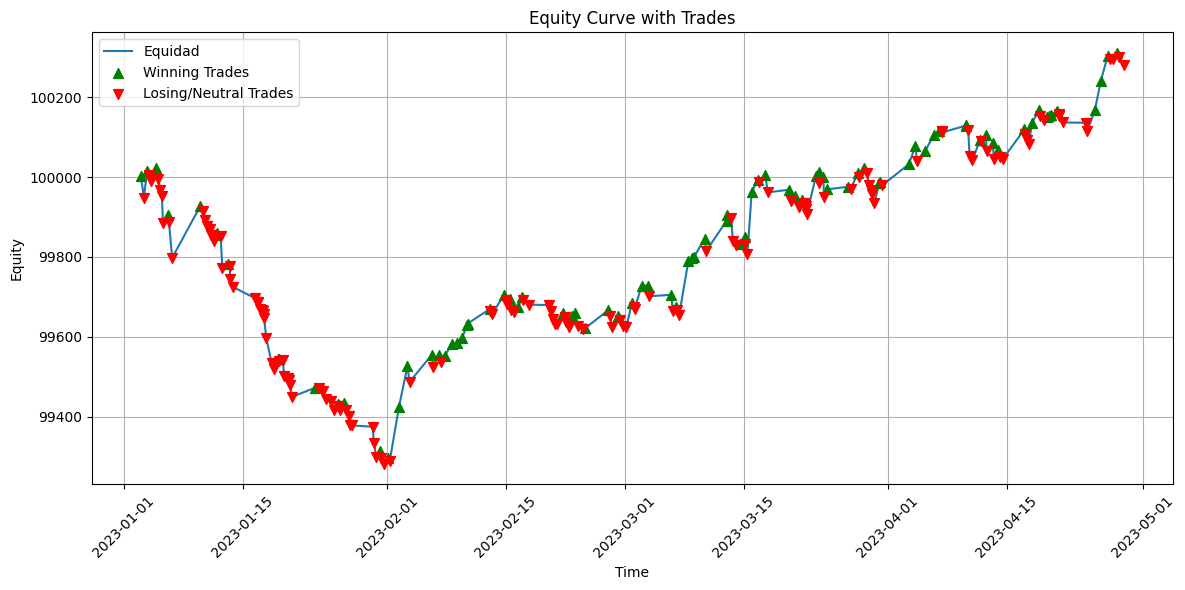

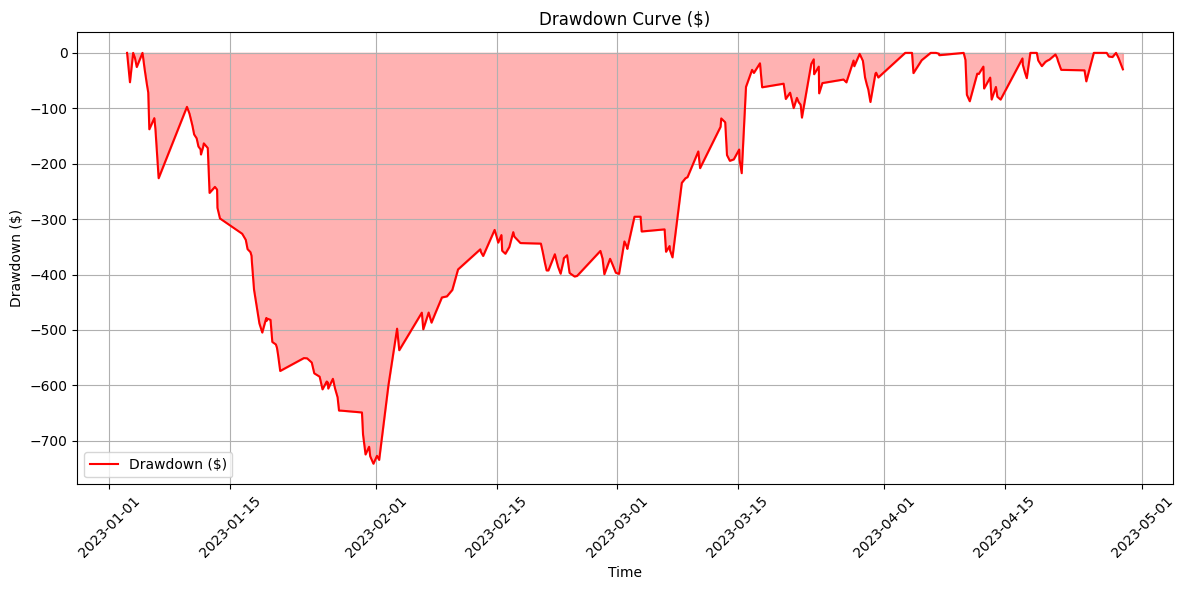

In [5]:
if not trade_log_df.empty:
    display.plot_win_loss_trades_bar_chart()
    display.plot_equity_curve_and_trades()
    display.plot_drawdown_curve()

else:
    print("No trades were executed.")